# Library

In [3]:
import os
import cv2
import re
import math
import glob
import nltk
import random
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction


import torch
from torch.utils.data import Dataset, DataLoader


from transformers import default_data_collator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast


device = 'cuda' if torch.cuda.is_available() else 'cpu'

!pip install evaluate
!pip install rouge_score
os.environ["WANDB_DISABLED"] = "true"

import evaluate

clear_output()


# Dataset

In [ ]:

class ImageCaptioningDataset(Dataset):
    """Image Captioning dataset"""

    def __init__(self, csv_file, max_length, tokenizer, feature_extractor):
        self.dataframe = pd.read_csv(csv_file)

        self.images = self.dataframe['image']
        self.captions = self.dataframe['caption']

        self.max_length = max_length

        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.dataframe)

    def tokenize(self, caption):
        tokens = self.tokenizer(caption,
                        padding="max_length",
                        max_length=self.max_length)
        return tokens.input_ids

    def extract_feature(self, image):
        encoder_inputs = self.feature_extractor(images=image, return_tensors="pt")
        return encoder_inputs.pixel_values

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_path = self.images[idx]

        image = cv2.imread(f'/kaggle/input/flickr8k/Images/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        input = dict()

        input['labels'] = self.tokenize(caption)
        input['pixel_values'] = torch.squeeze(self.extract_feature(image), dim=0)
        return input



# Model

In [ ]:
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
                                            image_encoder_model,
                                            text_decode_model)

feature_extractor = ViTImageProcessor.from_pretrained(image_encoder_model)
tokenizer = GPT2Tokenizer.from_pretrained(text_decode_model)

# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# Update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Utils

In [ ]:
ignore_pad_token_for_loss = True
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [ ]:
metric = evaluate.load("rouge")
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

# Train

In [ ]:
train_dataset = ImageCaptioningDataset('/kaggle/input/flickr8k-split/train.csv', 50, tokenizer, feature_extractor)
val_dataset = ImageCaptioningDataset('/kaggle/input/flickr8k-split/test.csv', 50, tokenizer, feature_extractor)

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="/kaggle/working",
    num_train_epochs=100,
    save_steps=1000,
)

In [ ]:
# Epoch Training Loss   Validation Loss   Rouge1      Rouge2     Rougel     Rougelsum     Gen Len
# 1     0.621400        0.599096          36.540200   12.610400  34.003000  33.998000     12.260413
# 2     0.540200        0.566682          40.131400   15.347000  37.332000  37.318700     11.929799
# 3     0.490600        0.555865          41.194300   16.309400  38.299800  38.308400     11.992708
# 4     0.414700        0.569516          42.166400   16.767800  39.240100  39.235700     11.747003
# 5     0.404900        0.565808          43.355400   18.029100  40.378700  40.385900     11.616487
# 6     0.368600        0.581545          43.476800   17.911400  40.389300  40.387000     11.969225
# 7     0.305700        0.624041          43.360900   17.813000  40.236100  40.222100     11.795205
# 8     0.304100        0.630653          43.555100   17.988400  40.528100  40.513700     11.607589
# 9     0.272900        0.661184          43.578000   17.914800  40.404400  40.397200     12.372018

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train('/kaggle/working/checkpoint-13000')

# Test

In [4]:
images = glob.glob('/kaggle/input/flickr8k/Images/*.jpg')

# Load model
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/vit-gpt").to(device)
tokenizer = GPT2TokenizerFast.from_pretrained("/kaggle/working/vit-gpt")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1128: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


A blonde horse and a blonde girl in a black sweatshirt are staring at a barrel of fire


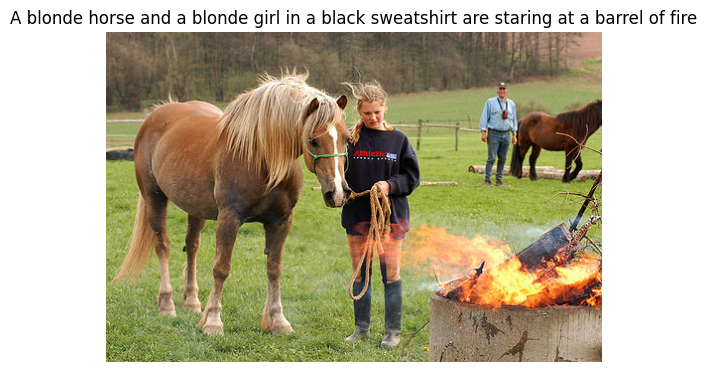

In [5]:
image = cv2.imread('/kaggle/input/flickr8k/Images/10815824_2997e03d76.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocess
pixel_values = image_processor(image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

# Autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

# Plot result
plt.imshow(image)
plt.title(generated_text)
plt.axis('off')
plt.show()

# BLEU Score

In [6]:
# Define new Dataset for BLEU score
class ImageCaptioningDataset(Dataset):
    """Image Captioning dataset"""

    def __init__(self, csv_file, tokenizer):
        self.dataframe = pd.read_csv(csv_file)

        self.images = sorted(os.listdir("/kaggle/input/flickr8k/Images"))
        self.captions = self.dataframe['caption']
        
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        captions = self.captions[5 * idx: 5 * idx + 5].tolist()
        image_path = self.images[idx]

        image = cv2.imread(f'/kaggle/input/flickr8k/Images/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        pixel_value = image_processor(image, return_tensors="pt").pixel_values
        pixel_value = torch.squeeze(pixel_value, dim=0)
        
        tokens = self.tokenizer(captions,
                        padding="max_length",
                        max_length=50)
        return pixel_value, torch.tensor(tokens.input_ids)

In [7]:
# Mapping target and prediction
def map_target(input):
    output = list()
    for group in input:
        temp = list()
        for cap in group:
            temp_cap = tokenizer.batch_decode([cap], skip_special_tokens=True)[0]
            temp.append(temp_cap.split(' '))
        output.append(temp)
    return output


def map_predict(input):
    output = list()
    for cap in input:
        cap = cap[:-1] + ' ' + cap[-1]
        output.append(cap.split(' '))
    return output

In [8]:
dataset = ImageCaptioningDataset(f"/kaggle/input/flickr8k/captions.txt", tokenizer)
loader = DataLoader(
                dataset=dataset,
                batch_size=64,
                num_workers=2)

In [9]:
weights=[(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]
for weight in weights: 
    list_of_references = []
    hypotheses = []
    bleu_score = []
    for idx, (images, targets) in tqdm(enumerate(iter(loader))):
        images = images.to(device)
        targets = map_target(targets)
        list_of_references.extend(targets)
        
        # Autoregressively generate caption (uses greedy decoding by default)
        generated_ids = model.generate(images, pad_token_id=tokenizer.eos_token_id)
        generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        generated_text = map_predict(generated_text)
        hypotheses.extend(generated_text)
        score = corpus_bleu(list_of_references, hypotheses, weights=weight)
        bleu_score.append(score)
    print(sum(bleu_score) / len(bleu_score))

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1128: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
127it [06:22,  3.01s/it]

0.7621735460228295



127it [06:22,  3.01s/it]

0.6759677407134652



127it [06:22,  3.01s/it]

0.5960145167739855



127it [06:22,  3.01s/it]

0.5202141876235903
